In [1]:
from pathlib import Path
from collections import defaultdict
import warnings
import math
import re
import time

import soundfile as sf
import numpy as np
import pykakasi
from lhotse import RecordingSet, Recording, SupervisionSegment, SupervisionSet, CutSet
from lhotse.recipes.utils import read_manifests_if_cached

In [96]:
src_dir = Path("/home/shahn/Documents/icefall_github/egs/reazonspeech/ASR/data/manifests")

dataset_parts = (
    # "train",
    "dev",
    # "test",
)

prefix = "reazonspeech"
suffix = "jsonl.gz"
print(f"Read manifests...")
manifests = read_manifests_if_cached(
    dataset_parts=dataset_parts,
    output_dir=src_dir,
    prefix=f"{prefix}_",
    suffix=suffix,
)
print(manifests)

Read manifests...
{'train': {'recordings': RecordingSet(len=592334), 'supervisions': SupervisionSet(len=592334)}}


In [4]:
with open("/home/shahn/Datasets/reazonspeech-v2/meta/medium.tsv", "r", encoding="utf-8") as f:
    text_list = [l.strip().split("	")[-1] for l in f.readlines()]

# Hiragana filtering

In [7]:
hiragana = set(['ゖ', 'ぉ', 'ぅ', 'ゔ', 'ぬ', 'ゆ', 'ど', 'ー', 'ぐ', 'げ', 'づ', 'お', 'ち', 'ぜ', 'ぺ', 'ぁ', 'ょ', 'こ', 'み', 'ろ', 'ぇ', 'び', 'だ', 'と', 'ほ', 'え', 'れ', 'じ', 'ぼ', 'た', 'ゃ', 'よ', 'ぎ', 'い', 'け', 'て', 'ふ', 'や', 'べ', 'す', 'り', 'は', 'ご', 'ね', 'し', 'も', 'ぱ', 'へ', 'め', 'ん', 'に', 'ぶ', 'む', 'で', 'う', 'ぴ', 'ひ', 'な', 'ゅ', 'ら', 'つ', 'る', 'か', 'せ', 'く', 'あ', 'の', 'が', 'さ', 'わ', 'ざ', 'ま', 'ぃ', 'ず', 'そ', 'ぞ', 'ぷ', 'ば', 'ぽ', 'を', 'き', 'っ'])
# katakana = set(['ー', 'ピ', 'ヅ', 'キ', 'ウ', 'タ', 'グ', 'ヲ', 'ツ', 'ヨ', 'ニ', 'ソ', 'イ', 'バ', 'テ', 'パ', 'ギ', 'デ', 'ジ', 'ラ', 'ッ', 'セ', 'ク', 'ェ', 'ア', 'モ', 'ワ', 'ゴ', 'ァ', 'ガ', 'ゼ', 'シ', 'ヘ', 'ロ', 'ミ', 'ョ', 'カ', 'コ', 'サ', 'チ', 'ヤ', 'ト', 'ム', 'ゲ', 'ド', 'ビ', 'ス', 'ザ', 'ン', 'ダ', 'エ', 'ネ', 'メ', 'ブ', 'オ', 'ナ', 'フ', 'ゾ', 'ィ', 'ペ', 'レ', 'プ', 'ユ', 'ボ', 'マ', 'ケ', 'ル', 'ベ', 'ヒ', 'ズ', 'ノ', 'ハ', 'ャ', 'ュ', 'リ', 'ホ', 'ポ'])
# roman = set("abcdefghijklmnopqrstuvwxyz")
# len(hiragana), len(katakana), len(roman)

In [8]:
normalization_rules = [
    ["きゃ", "캬"], ["きゅ", "큐"], ["きょ", "쿄"],
    ["しゃ", "샤"], ["しゅ", "슈"], ["しょ", "쇼"],
    ["ちゃ", "챠"], ["ちゅ", "츄"], ["ちょ", "쵸"],
    ["にゃ", "냐"], ["にゅ", "뉴"], ["にょ", "뇨"],
    ["ひゃ", "햐"], ["ひゅ", "휴"], ["ひょ", "효"],
    ["ぎゃ", "먀"], ["みゅ", "뮤"], ["みょ", "묘"],
    ["りゃ", "랴"], ["りゅ", "류"], ["りょ", "료"],
    ["みゃ", "갸"], ["ぎゅ", "규"], ["じょ", "교"],
    ["じゃ", "자"], ["じゅ", "주"], ["ぎょ", "조"],
    ["ぢゃ", "자"], ["ぢゅ", "주"], ["ぢょ", "조"],
    ["びゃ", "뱌"], ["びゅ", "뷰"], ["びょ", "뵤"],
    ["ぴゃ", "퍄"], ["ぴゅ", "퓨"], ["ぴょ", "표"],
    ["い", "이"], ["ゐ", "이"],
    ["え", "에"], ["ゑ", "에"],
    ["お", "오"], ["を", "오"],
    ["じ", "지"], ["ぢ", "지"],
    ["ず", "주"], ["づ", "주"],
]
hiragana.update(set([x[1] for x in normalization_rules]))

In [14]:
vocab = set()
num_processed = 0
num_filtered = 0

with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kakasi = pykakasi.kakasi()
        kakasi.setMode("K", "H")
        kakasi.setMode("H", None)
        kakasi.setMode("J", "H")
        converter = kakasi.getConverter()
    
        for idx, text in enumerate(text_list[:1000]):
            text = re.sub("[『』「」［］〈〉・♪《》−．？！⁉“”◆）‼≪]", " ", text)
            output = converter.do(text)
            output = output.replace("、", "").replace("。", "").replace(" ", "")
            for rule in normalization_rules:
                output = output.replace(rule[0], rule[1])
            filtered = False
            for word in output:
                # vocab.add(word)
                if word not in hiragana:
                    # num_filtered += 1
                    # filtered = True
                    # break
                    if not filtered:
                        print(f"[{word}", end="")
                        filtered = True
                    else:
                        print(f", {word}", end="")
                else:
                    vocab.add(word)
            if filtered:
                print(f"], {text}")
            # if not filtered:
            #     num_processed += 1
# print(num_processed, num_filtered)
# print(vocab)

[１, ｍ], さてここまで直線を表す方程式がどのような直線になるかを見てきましたがここからは逆にある１点を通って傾きｍの直線がどのような方程式で表されるのかを考えてみましょう。
[１], 最後はセカンドフライで１回を三者凡退に抑えた大谷投手。
[１], あとはもう１つは鉄道って信頼性がある要するに分単位で旅行ができる。
[６, ９], ご覧のとおり、午前６時からずっと夜の９時まで晴れマークが並びますね。
[１, ３, ０], 樹齢１３０年の八重紅
[２, ０, ２, ０], この最初の２０分南アフリカ、データでは最初の２０分は失点が非常に少ないチームなんですが。
[１, １], アジア勢で唯一１勝した日本が１位で残りは得失点差で順位が決まっています。
[２, ０], 診療所の行形毅先生は２０年来すずの会の活動を医療の面から支えてきました。
[Ｏ, Ｋ], 動物植物人間でも神様でも名乗ればＯＫ 
[４, １, ５], 時刻は４時１５分です。
[１, ７, ０, ０], １日の感染確認が７００人を超えるのは、次のニュースです。
[２], いや２時間の旅ですから寄り道は我慢です。
[２, ６, ０, ０], 矢部さんでプラス２６００円です。
[３, ０, ７, ０], ３０平方メートルが焼け、７０代の男性が病院に搬送されましたが命に別状はなかったということです。
[１, ２], この１、２番の出塁を全力で抑えにいく必要があるんですね、ガンケルは。
[３], かっぱのきょねんぬけたは３ぼんなんだね。
[１, ＝, １, ５, １, １, ４, ４], 一昨日、円相場は一時１ドル＝１５１円台後半まで値下がりしましたがその後、一転して円が買い戻されロイター通信によりますと一時、１４４円台まで急騰しました。
[３, ３], 試合は３対３の団体戦です。
[９, ０, ０], これも税抜きやったら９００なんぼとかなのでめちゃめちゃ安いし今日やろうってなってもすぐ買いに行けるんでオススメです。
[２, ３], 水戸は２３度ですが、きょうよりもちょっと上がります。
[１], １回、アドレスをほどいて、何を思ったんでしょうね。
[ｘ, １], ｘ １でわり切れるからですね。
[４, ２, ０], 知恵の書を見ることができる合格ラインは４２０ほぉじゃ。
[１, １], 今日午前１１時半ごろ

# Katakana filtering using SudachiPy

In [136]:
from sudachipy import Dictionary
sudachi = Dictionary(dict='full').create()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kakasi = pykakasi.kakasi()
    kakasi.setMode("K", None)
    kakasi.setMode("H", "K")
    kakasi.setMode("J", None)
    kakasi.setMode("a", None)
    kakasi.setMode("E", None)
    hira_to_kata = kakasi.getConverter()

def encode_sudachi(text, kakasi: bool = True):
    morpheme_list = sudachi.tokenize(text)
    katakana = ""
    for morpheme in morpheme_list:
        if morpheme.surface() in [" ", "、", "。"]:
            continue
        katakana = f"{katakana}{morpheme.reading_form()}"
    katakana = katakana.replace("ー", "").replace("・", "")

    if kakasi:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            katakana = hira_to_kata.do(katakana)
    return katakana

NORMALIZATION_RULES = [
    ['キャ', '캬', 'kya'], ['キュ', '큐', 'kyu'], ['キョ', '쿄', 'kyo'],
    ['シャ', '샤', 'sha'], ['シュ', '슈', 'shu'], ['ショ', '쇼', 'sho'],
    ['チャ', '챠', 'cha'], ['チュ', '츄', 'chu'], ['チョ', '쵸', 'cho'],
    ['ニャ', '냐', 'nya'], ['ニュ', '뉴', 'nyu'], ['ニョ', '뇨', 'nyo'],
    ['ヒャ', '햐', 'hya'], ['ヒュ', '휴', 'hyu'], ['ヒョ', '효', 'hyo'],
    ['ミャ', '먀', 'mya'], ['ミュ', '뮤', 'myu'], ['ミョ', '묘', 'myo'],
    ['リャ', '랴', 'rya'], ['リュ', '류', 'ryu'], ['リョ', '료', 'ryo'],
    ['ギャ', '갸', 'gya'], ['ギュ', '규', 'gyu'], ['ジョ', '교', 'gyo'],
    ['ビャ', '뱌', 'bya'], ['ビュ', '뷰', 'byu'], ['ビョ', '뵤', 'byo'],
    ['ピャ', '퍄', 'pya'], ['ピュ', '퓨', 'pyu'], ['ピョ', '표', 'pyo']
]
HOMONYM_RULES = [
    ['ジャ', '자', 'ja'], ['ジュ', '주', 'ju'], ['ギョ', '조', 'jo'],
    ['ヂャ', '자', 'ja'], ['ヂュ', '주', 'ju'], ['ヂョ', '조', 'jo'],
    ['イ', '이', 'i'], ['ヰ', '이', 'i'],
    ['エ', '에', 'e'], ['ヱ', '에', 'e'],
    ['オ', '오', 'o'], ['ヲ', '오', 'o'],
    ['ジ', '지', 'ji'], ['ヂ', '지', 'ji'],
    ['ズ', '주', 'zu'], ['ヅ', '주', 'zu']
]
KATAKANA = set(['ヶ', 'ォ', 'ゥ', 'ヴ', 'ヌ', 'ユ', 'ド', 'ー', 'グ', 'ゲ', 'ヅ', 'オ', 'チ', 'ゼ', 'ペ', 'ァ', 'ョ', 'コ', 'ミ', 'ロ', 'ェ', 'ビ', 'ダ', 'ト', 'ホ', 'エ', 'レ', 'ジ', 'ボ', 'タ', 'ャ', 'ヨ', 'ギ', 'イ', 'ケ', 'テ', 'フ', 'ヤ', 'ベ', 'ス', 'リ', 'ハ', 'ゴ', 'ネ', 'シ', 'モ', 'パ', 'ヘ', 'メ', 'ン', 'ニ', 'ブ', 'ム', 'デ', 'ウ', 'ピ', 'ヒ', 'ナ', 'ュ', 'ラ', 'ツ', 'ル', 'カ', 'セ', 'ク', 'ア', 'ノ', 'ガ', 'サ', 'ワ', 'ザ', 'マ', 'ィ', 'ズ', 'ソ', 'ゾ', 'プ', 'バ', 'ポ', 'ヲ', 'キ', 'ッ'] + [x[1] for x in NORMALIZATION_RULES] + [x[1] for x in HOMONYM_RULES])

In [163]:
vocab = set()
num_processed = 0
num_filtered = 0

with open("/home/shahn/Datasets/reazonspeech-v2/meta/large.tsv", "r") as file:
    wav_text_list = []
    for i in range(2000):
        _, text = file.readline().strip().split("\t")
        text = re.sub("[［］〈〉・♪《》−．？！⁉“”◆）‼≪]", " ", text)
        output = encode_sudachi(text)
        for rule in NORMALIZATION_RULES:
            output = output.replace(rule[0], rule[1])
        for rule in HOMONYM_RULES:
            output = output.replace(rule[0], rule[1])
        filtered = False
        for word in output:
            vocab.add(word)
            if word not in KATAKANA:
                if not filtered:
                    print(f"[{word}", end="")
                    filtered = True
                else:
                    print(f", {word}", end="")
            else:
                vocab.add(word)
        if filtered:
            num_filtered += 1
            print(f"], {text}")
        if not filtered:
            num_processed += 1
print(num_processed, num_filtered)
print(vocab)
print([x for x in KATAKANA if x not in vocab])

[=], 一昨日、円相場は一時１ドル＝１５１円台後半まで値下がりしましたがその後、一転して円が買い戻されロイター通信によりますと一時、１４４円台まで急騰しました。
[x], ｘ １でわり切れるからですね。
[x], 空気中から集めた水分に高電圧をかけて生み出すナノサイズのイオンナノイーＸ。
[=], 昨日、日本政府は新たにＯＤＡ＝政府開発援助によるおよそ３６億円の緊急支援を決定。
[b, o, o, n, a], 森田さん、Ｂｏｏｎａちゃん。
[q], タマ電Ｑ見つけた 
[錺], この伝統的な錺金具作りなんですけど今後どういった展開を考えていらっしゃいますか 
[c, o, n, t, i, n, u, e, s], 僕の中にも入っているいろんな人生観とかも含めてですけどその「Ｃｏｎｔｉｎｕｅｓ」っていうそのツアーがあってそれを僕がまた受け継いでそれをまた違ったコンセプトでショーにしてみたいなことができれば
[b, c, z], 本日はＡ Ｂ Ｃ Ｚの皆さんありがとうございました 
[禺, 輒], 禺輒落ち着いて車庫へと下がっていく大島さん 
[泳], 入江選手は今大会１００ｍ、銀メダル、５０ｍ銅メダルなわけですが、１００ｍ泳ぐことになりますが１００ｍの金が中国の徐嘉余、銀が入江選手で銅に韓国のイ ジュホ選手ということで１００ｍの金 銀 銅が１泳でぶつかってくるわけですよね。
[d], 「ストレートアイロンナノケア」３Ｄ密着プレートと３つの温度コントロール機能搭載。
[b], 集合Ａと集合Ｂのどちらにも含まれていますよね。
[x, y, x, p, q, p], そうすれば例えば「Ｘという状態の高齢者にＹという介護を行えば１年後にＸ’という状態に改善する」あるいは「Ｐという状態の高齢者にＱという介護を行えばＰを悪化させずに済む」ということが明示できるようになります。
1986 14
{'x', 'ブ', 'カ', 'デ', 'ポ', 'q', 'ゾ', 'リ', 'ヌ', 'ン', '표', 'ク', 'プ', 'p', '쵸', 'ボ', 'サ', 'ォ', '먀', 'テ', 'ペ', 'ロ', '조', '뉴', 'マ', 'ェ', 'ト', 'ム', 'モ', 's', 'b', 'メ', 'ニ', '이', '에', '오', 'ソ', 'ホ', 'ア'

In [144]:
with open("/home/shahn/Datasets/reazonspeech-v2/meta/large.tsv", "r") as f:
    print(f.readline())
    print(f.readline())

000/000734dcb35d6.flac	これまたジミーさん

000/0024ae5c517e7.flac	今も相手にロンバルドのほうに肩口で握られてもすぐさま流れを切る引き込み返しに変えたと。



In [160]:
text = "２００万円果た"
print(encode_sudachi(text, kakasi=False))
print(encode_sudachi(text, kakasi=True))
for morpheme in sudachi.tokenize(text):
    print(f"{morpheme.surface()} -> {morpheme.reading_form()}")

ニレイレイマンエンカタ
ニレイレイマンエンカタ
２００万 -> ニレイレイマン
円 -> エン
果 -> カ
た -> タ


In [159]:
print(re.match(r"Ａ", "昨日、日本政府は新たにＯＤＡ＝政府開発援助によるおよそ３６億円の緊急支援を決定。"))

None


In [127]:
!echo "ギブアンドテイクこちらは命を与えます" | sudachipy -s full -a

ギブアンドテイク	名詞,普通名詞,一般,*,*,*	ギブアンドテイク	ギブアンドテイク	ギブ・アンド・テイク	0	[9948]
こちら	代名詞,*,*,*,*,*	此方	こちら	コチラ	0	[]
は	助詞,係助詞,*,*,*,*	は	は	ハ	0	[]
命	名詞,普通名詞,一般,*,*,*	命	命	イノチ	0	[13292]
を	助詞,格助詞,*,*,*,*	を	を	ヲ	0	[]
与え	動詞,一般,*,*,下一段-ア行,連用形-一般	与える	与える	アタエ	0	[]
ます	助動詞,*,*,*,助動詞-マス,終止形-一般	ます	ます	マス	0	[]
EOS


# CheckList

In [5]:
import warnings
import pykakasi

kakasi = pykakasi.kakasi()
text = "あれが今日のおやつですぅ。"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kakasi.setMode("H", "K")
    kakasi.setMode("J", "K")
    kakasi_kata = kakasi.getConverter()
    print(kakasi_kata.do(text))
    kakasi.setMode("K", "a")
    kakasi.setMode("H", "a")
    kakasi.setMode("J", "a")
    kakasi_roma = kakasi.getConverter()
    print(kakasi_roma.do(text))

アレガキョウノオヤツデスゥ。
aregakyounooyatsudesuu。


In [23]:
checklist = [
    ["今日は暑いですね。", "Kyou wa atsui desu ne"],
    ["きょうは あついですね。", "Kyou wa atsui desu ne"],
    ["今日の社会では、技術が進歩している。", "Konnichi no shakai de wa, gijutsu ga shinpo shiteiru"],
    ["こんにちの しゃかいでは、ぎじゅつが しんぽしている。", "Konnichi no shakai de wa, gijutsu ga shinpo shiteiru"],
    ["風邪が大分よくなった。", "Kaze ga daibu yoku natta"],
    ["かぜが だいぶ よくなった。", "Kaze ga daibu yoku natta"],
    ["大分県に旅行に行きました。", "Oita-ken ni ryokou ni ikimashita"],
    ["おおいたけんに りょこうに いきました。", "Oita-ken ni ryokou ni ikimashita"],
    ["彼は英語が上手だ。", "Kare wa eigo ga jouzu da"],
    ["かれは えいごが じょうずだ。", "Kare wa eigo ga jouzu da"],
    ["舞台の上手に立ってください。", "Butai no kamite ni tatte kudasai"],
    ["ぶたいの かみてに たってください。", "Butai no kamite ni tatte kudasai"],
    ["彼は交渉が上手だね。", "Kare wa koushou ga uwate da ne"], 
    ["かれは こうしょうが うわてだね。", "Kare wa koushou ga uwate da ne"],
    ["彼は生を全うした。", "Kare wa sei o mattou shita"],
    ["かれは せいを まっとうした。", "Kare wa sei o mattou shita"],
    ["生ビールをください。","Nama biiru o kudasai"],
    ["なまビールを ください。","Nama biiru o kudasai"],
    ["生きる意味を考える。", "Ikiru imi o kangaeru"],
    ["いきる いみを かんがえる。", "Ikiru imi o kangaeru"],
    ["彼はまだ生な青年だ。", "Kare wa mada ubu na seinen da"],
    ["かれは まだ うぶな せいねんだ。", "Kare wa mada ubu na seinen da"],
    ["彼の行方がわからない。", "Kare no yukue ga wakaranai"],
    ["かれの ゆくえが わからない。", "Kare no yukue ga wakaranai"],
    ["彼は行方を学んでいる。", "Kare wa gyouhou o manande iru"],
    ["かれは ぎょうほうを まなんでいる。", "Kare wa gyouhou o manande iru"],
]

# Pykakasi

In [65]:
kakasi2 = pykakasi.kakasi()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kakasi2.setMode("H", "K")
    kakasi2.setMode("J", "K")
    kakasi2 = kakasi2.getConverter()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for text, roman in checklist:
        print(f"input   : {text}")
        katakana = kakasi2.do(text)
        print(f"enc_kata: {katakana}")
        print(f"enc_roma: {conv.do(katakana)}")
        print(f"answer  : {roman}", end="\n\n")

input   : 今日は暑いですね。
enc_kata: コンニチハアツイデスネ。
enc_roma: konnichihaatsuidesune。
answer  : Kyou wa atsui desu ne

input   : きょうは あついですね。
enc_kata: キョウハ アツイデスネ。
enc_roma: kyouha atsuidesune。
answer  : Kyou wa atsui desu ne

input   : 今日の社会では、技術が進歩している。
enc_kata: キョウノシャカイデハ、ギジュツガシンポシテイル。
enc_roma: kyounoshakaideha、gijutsugashinposhiteiru。
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : こんにちの しゃかいでは、ぎじゅつが しんぽしている。
enc_kata: コンニチノ シャカイデハ、ギジュツガ シンポシテイル。
enc_roma: konnichino shakaideha、gijutsuga shinposhiteiru。
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : 風邪が大分よくなった。
enc_kata: カゼガオオイタヨクナッタ。
enc_roma: kazegaooitayokunatta。
answer  : Kaze ga daibu yoku natta

input   : かぜが だいぶ よくなった。
enc_kata: カゼガ ダイブ ヨクナッタ。
enc_roma: kazega daibu yokunatta。
answer  : Kaze ga daibu yoku natta

input   : 大分県に旅行に行きました。
enc_kata: オオイタケンニリョコウニイキマシタ。
enc_roma: ooitakenniryokouniikimashita。
answer  : Oita-ken ni ryokou ni ikimashita

input   : おおいたけんに りょこうに いきました。
en

# unidic-lite

In [50]:
import MeCab
import unidic_lite

mecab = MeCab.Tagger('-d ' + unidic_lite.DICDIR)

def encode(text):
    text = text.replace("、", "").replace("。", "")
    parsed_text = mecab.parse(text)
    katakana = ""

    for line in parsed_text.splitlines():
        if line == 'EOS':
            break
        parts = line.split('\t')
        part = parts[1]
        if part == "":
            return f">>> ERROR - failed to convert {parts[0]}"
        katakana = f"{katakana}{part} "

    return katakana

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for text, roman in checklist:
        print(f"input   : {text}")
        katakana = encode(text)
        print(f"enc_kata: {katakana}")
        print(f"enc_roma: {conv.do(katakana)}")
        print(f"answer  : {roman}", end="\n\n")

input   : 今日は暑いですね。
enc_kata: キョー ワ アツイ デス ネ 
enc_roma: kyoo wa atsui desu ne 
answer  : Kyou wa atsui desu ne

input   : きょうは あついですね。
enc_kata: キョー ワ アツイ デス ネ 
enc_roma: kyoo wa atsui desu ne 
answer  : Kyou wa atsui desu ne

input   : 今日の社会では、技術が進歩している。
enc_kata: キョー ノ シャカイ デ ワ ギジュツ ガ シンポ シ テ イル 
enc_roma: kyoo no shakai de wa gijutsu ga shinpo shi te iru 
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : こんにちの しゃかいでは、ぎじゅつが しんぽしている。
enc_kata: コンニチ ノ シャカイ デ ワ ギジュツ ガ シン ポ シ テ イル 
enc_roma: konnichi no shakai de wa gijutsu ga shin po shi te iru 
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : 風邪が大分よくなった。
enc_kata: カゼ ガ ダイブ ヨク ナッ タ 
enc_roma: kaze ga daibu yoku natsu ta 
answer  : Kaze ga daibu yoku natta

input   : かぜが だいぶ よくなった。
enc_kata: カゼ ガ ダイブ ヨク ナッ タ 
enc_roma: kaze ga daibu yoku natsu ta 
answer  : Kaze ga daibu yoku natta

input   : 大分県に旅行に行きました。
enc_kata: オーイタ ケン ニ リョコー ニ イキ マシ タ 
enc_roma: ooita ken ni ryokoo ni iki mashi ta 
a

# ipadic

In [51]:
import ipadic

ipadic = MeCab.Tagger(ipadic.MECAB_ARGS)

def encode_ipadic(text):
    parsed_text = ipadic.parse(text)
    katakana = ""

    for line in parsed_text.splitlines():
        if line.strip() == 'EOS':
            break
        parts = line.split(',')
        if len(parts) <= 7:
            word = parts[0].split('\t')[0]
            return f">>> ERROR - failed to convert {word}"
        part = parts[7]
        if part == "":
            part = line.split("\t")[0]
        katakana = f"{katakana}{part} "

    return katakana

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for text, roman in checklist:
        print(f"input   : {text}")
        katakana = encode_ipadic(text)
        print(f"enc_kata: {katakana}")
        print(f"enc_roma: {conv.do(katakana)}")
        print(f"answer  : {roman}", end="\n\n")

input   : 今日は暑いですね。
enc_kata: キョウ ハ アツイ デス ネ 。 
enc_roma: kyou ha atsui desu ne 。 
answer  : Kyou wa atsui desu ne

input   : きょうは あついですね。
enc_kata: キョウ ハ アツイ デス ネ 。 
enc_roma: kyou ha atsui desu ne 。 
answer  : Kyou wa atsui desu ne

input   : 今日の社会では、技術が進歩している。
enc_kata: キョウ ノ シャカイ デ ハ 、 ギジュツ ガ シンポ シ テ イル 。 
enc_roma: kyou no shakai de ha 、 gijutsu ga shinpo shi te iru 。 
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : こんにちの しゃかいでは、ぎじゅつが しんぽしている。
enc_kata: >>> ERROR - failed to convert ぎじゅつが
enc_roma: >>> ERROR - failed to convert gijutsuga
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : 風邪が大分よくなった。
enc_kata: カゼ ガ オオイタ ヨク ナッ タ 。 
enc_roma: kaze ga ooita yoku natsu ta 。 
answer  : Kaze ga daibu yoku natta

input   : かぜが だいぶ よくなった。
enc_kata: カゼ ガ ダイブ ヨク ナッ タ 。 
enc_roma: kaze ga daibu yoku natsu ta 。 
answer  : Kaze ga daibu yoku natta

input   : 大分県に旅行に行きました。
enc_kata: オオイタ ケン ニ リョコウ ニ イキ マシ タ 。 
enc_roma: ooita ken ni ryokou ni iki 

# Sudachi

In [64]:
from sudachipy import Dictionary
sudachi = Dictionary(dict='full').create()

def encode_sudachi(text):
    text = text.replace("、", "").replace("。", "")
    morpheme_list = sudachi.tokenize(text)
    katakana = ""
    for morpheme in morpheme_list:
        if morpheme.surface() == " ":
            continue
        katakana = f"{katakana}{morpheme.reading_form()} "
    return katakana

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for text, roman in checklist:
        print(f"input   : {text}")
        katakana = encode_sudachi(text)
        print(f"enc_kata: {katakana}")
        print(f"enc_roma: {conv.do(katakana)}")
        print(f"answer  : {roman}", end="\n\n")

input   : 今日は暑いですね。
enc_kata: キョウ ハ アツイ デス ネ 
enc_roma: kyou ha atsui desu ne 
answer  : Kyou wa atsui desu ne

input   : きょうは あついですね。
enc_kata: キョウ ハ アツイ デス ネ 
enc_roma: kyou ha atsui desu ne 
answer  : Kyou wa atsui desu ne

input   : 今日の社会では、技術が進歩している。
enc_kata: キョウ ノ シャカイ デ ハ ギジュツ ガ シンポ シ テ イル 
enc_roma: kyou no shakai de ha gijutsu ga shinpo shi te iru 
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : こんにちの しゃかいでは、ぎじゅつが しんぽしている。
enc_kata: コンニチ ノ シャカイ デ ハ ギジュツ ガ シン ポ シ テ イル 
enc_roma: konnichi no shakai de ha gijutsu ga shin po shi te iru 
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : 風邪が大分よくなった。
enc_kata: カゼ ガ ダイブ ヨク ナッ タ 
enc_roma: kaze ga daibu yoku natsu ta 
answer  : Kaze ga daibu yoku natta

input   : かぜが だいぶ よくなった。
enc_kata: カゼ ガ ダイブ ヨク ナッ タ 
enc_roma: kaze ga daibu yoku natsu ta 
answer  : Kaze ga daibu yoku natta

input   : 大分県に旅行に行きました。
enc_kata: オオイタケン ニ リョコウ ニ イキ マシ タ 
enc_roma: ooitaken ni ryokou ni iki mashi ta 
ans

In [70]:
print("[", end="")
for morpheme in sudachi.tokenize("彼はまだ生な青年だ。"):
    print(f"'{morpheme.surface()}',", end=" ")
print("]")

['彼', 'は', 'まだ', '生', 'な', '青年', 'だ', '。', ]


# OpenJTalk

In [67]:
import pyopenjtalk

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for text, roman in checklist:
        print(f"input   : {text}")
        katakana = pyopenjtalk.g2p(text, kana=True)
        print(f"enc_kata: {katakana}")
        print(f"enc_roma: {conv.do(katakana)}")
        print(f"answer  : {roman}", end="\n\n")

input   : 今日は暑いですね。
enc_kata: キョーワアツイデスネ。
enc_roma: kyoowaatsuidesune。
answer  : Kyou wa atsui desu ne

input   : きょうは あついですね。
enc_kata: キョーワ　アツイデスネ。
enc_roma: kyoowa　atsuidesune。
answer  : Kyou wa atsui desu ne

input   : 今日の社会では、技術が進歩している。
enc_kata: キョーノシャカイデワ、ギジュツガシンポシテイル。
enc_roma: kyoonoshakaidewa、gijutsugashinposhiteiru。
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : こんにちの しゃかいでは、ぎじゅつが しんぽしている。
enc_kata: コンニチノ　シャカイデワ、ギジュツガ　シンポシテイル。
enc_roma: konnichino　shakaidewa、gijutsuga　shinposhiteiru。
answer  : Konnichi no shakai de wa, gijutsu ga shinpo shiteiru

input   : 風邪が大分よくなった。
enc_kata: カゼガダイブヨクナッタ。
enc_roma: kazegadaibuyokunatta。
answer  : Kaze ga daibu yoku natta

input   : かぜが だいぶ よくなった。
enc_kata: カゼガ　ダイブ　ヨクナッタ。
enc_roma: kazega　daibu　yokunatta。
answer  : Kaze ga daibu yoku natta

input   : 大分県に旅行に行きました。
enc_kata: オーイタケンニリョコーニイキマシタ。
enc_roma: ooitakenniryokooniikimashita。
answer  : Oita-ken ni ryokou ni ikimashita

input   : おおいたけんに りょこうに いきました。
enc_kata

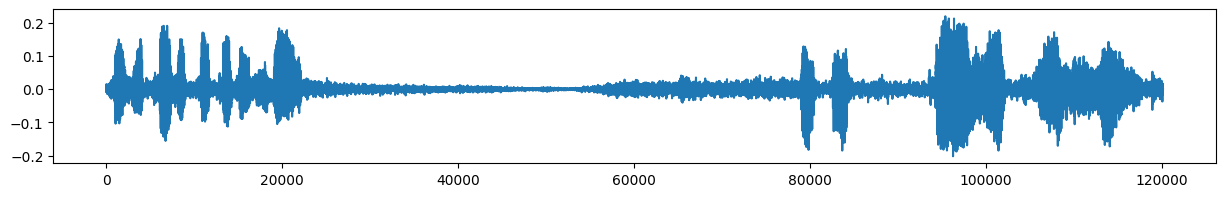

In [9]:
%matplotlib inline
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
    
wav, sr = librosa.load("/home/shahn/Datasets/reazonspeech-v2/audio/000/6b12f43feff26.flac")
ipd.display(ipd.Audio(wav, rate=16_000, normalize=False))
plt.figure(figsize=(15, 2))
plt.plot(wav)
plt.show()